In [4]:
# ⚙️ 必要ライブラリ読み込み
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced
import os

# ── フォント設定（日本語ラベル用）──────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
else:
    font_prop = None

# # ========= notebook parameters =========
args = SimpleNamespace(
    curr         = "../../data/shared/embeddings.npy",   # 既存サービスの埋め込み (n_services × D)
    fut          = "../VAE/emb_new.npy",      # 新規サンプルの埋め込み   (N_new × D)
    mass_curr    = None,                                 # CSVで行列重み付けしたい場合パス指定
    plot_detail  = True,                                 # 可視化ON/OFF
)



In [5]:
# ──────────────────────────────────────────────
# 1. 埋め込みロード &（任意）標準化
# ──────────────────────────────────────────────
X_curr = np.load(args.curr)  # shape = (n_services, dim)
Y_fut  = np.load(args.fut)   # shape = (n_new,      dim)

# 標準化（埋め込み分布のスケール揃え推奨）
scaler = StandardScaler()
X_curr = scaler.fit_transform(X_curr)
Y_fut  = scaler.transform(Y_fut)



In [6]:
# ──────────────────────────────────────────────
# 2. 質量ベクトル a の設定（既存サービス＋非ユーザー仮想ノード）
# ──────────────────────────────────────────────
xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
title_code = {v:k for k,v in code_title.items()}

counts = df_raw["SQ6_2"].value_counts().sort_index()
shares = counts / counts.sum()

import pickle
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
mass_curr = []
for svc in feat_df.index:
    code = title_code.get(svc)
    mass_curr.append(shares.get(code, 0.0))
mass_curr = np.array(mass_curr, dtype=float)
service_names = feat_df.index.tolist()

# 非ユーザーの割合を仮定的に決める（例：市場の30%が未利用者）
nonuser_mass = 0.3
a = np.append(np.maximum(mass_curr, 1e-12), nonuser_mass)
a /= a.sum()

# 既存＋非ユーザー名
all_source_names = service_names + ["(非ユーザー)"]

n = X_curr.shape[0]
m = Y_fut.shape[0]



In [8]:
# ──────────────────────────────────────────────
# 3. 新サービス候補1つずつに対してOTを実施
# ──────────────────────────────────────────────
def compute_cost_matrix(X: np.ndarray, Y: np.ndarray, metric="euclidean") -> np.ndarray:
    """
    コスト行列 (pairwise_distances) を計算するラッパー関数
    """
    from sklearn.metrics import pairwise_distances
    return pairwise_distances(X, Y, metric=metric)



eps = 0.2
tau = 0.1
total_market_size = 10000000   # 仮の全体市場規模（人）
arpu = 1200                   # 仮の月額課金（円）

results = []
for idx in range(m):
    # 既存 + 非ユーザーのベクトル (n+1, dim)
    Y_single = Y_fut[idx].reshape(1, -1)
    X_all = np.vstack([X_curr, Y_single*0])   # 非ユーザーには空ベクトルや平均でもOK

    # コスト行列: 既存サービス・非ユーザー → 新サービス（1点）
    D_existing = compute_cost_matrix(X_curr, Y_single, metric='cosine')   # (n,1)
    D_nonuser  = np.array([[1.0]])  # 非ユーザー→新サービスへのコスト（仮。1.0=やや遠い）
    D = np.vstack([D_existing, D_nonuser])     # (n+1, 1)
    D = D / np.median(D)

    b = np.array([1.0])  # 新サービス1点だけに質量

    # Unbalanced OT
    T = sinkhorn_unbalanced(a, b, D, reg=eps, reg_m=tau)
    inbound_total  = T.sum()        # この新サービスへの総流入（massのスケールで）
    inbound_users  = inbound_total * total_market_size

    from_existing  = T[:-1, 0].sum()
    from_nonuser   = T[-1, 0]
    # 新規獲得比率
    bo_ratio = from_nonuser / inbound_total if inbound_total > 0 else 0

    # Novelty: 新サービスベクトルの既存サービスからの最小距離
    novelty = D_existing.min()

    # ブルーオーシャンスコア: 非ユーザーからの流入 × novelty
    blue_score = from_nonuser * novelty

    # 売上予測
    estimated_sales = inbound_users * arpu

    results.append({
        "service": f"new{idx}",
        "from_existing": from_existing * total_market_size,
        "from_nonuser": from_nonuser * total_market_size,
        "total_inflow": inbound_users,
        "nonuser_ratio": bo_ratio,
        "novelty": novelty,
        "BlueOceanScore": blue_score,
        "estimated_sales": estimated_sales
    })

# DataFrame化・ランキング
df_result = pd.DataFrame(results).sort_values("BlueOceanScore", ascending=False)

# 保存
os.makedirs("results", exist_ok=True)
df_result.to_csv("results/scores.csv", index=False)



=== Blue-Ocean Score TOP10 ===


,service,from_existing,from_nonuser,total_inflow,nonuser_ratio,novelty,BlueOceanScore,estimated_sales
15,new15,5.406167e+05,206674.916293,7.472916e+05,0.276565,0.678453,0.014022,8.967500e+08
17,new17,5.677879e+05,198883.365467,7.666713e+05,0.259412,0.694792,0.013818,9.200055e+08
7,new7,4.874870e+05,200874.221330,6.883612e+05,0.291815,0.592847,0.011909,8.260334e+08
18,new18,6.418645e+05,212008.926737,8.538734e+05,0.248291,0.552781,0.011719,1.024648e+09
13,new13,5.555164e+05,195155.012648,7.506714e+05,0.259974,0.579489,0.011309,9.008057e+08
11,new11,7.385610e+05,227887.597170,9.664486e+05,0.235799,0.408673,0.009313,1.159738e+09
3,new3,6.499931e+05,162168.894676,8.121620e+05,0.199676,0.347248,0.005631,9.745944e+08
1,new1,9.152557e+05,172461.060767,1.087717e+06,0.158553,0.280981,0.004846,1.305260e+09
6,new6,1.316890e+06,155889.571370,1.472780e+06,0.105847,0.301840,0.004705,1.767336e+09
0,new0,1.380091e+06,106226.814235,1.486318e+06,0.071470,0.441945,0.004695,1.783582e+09


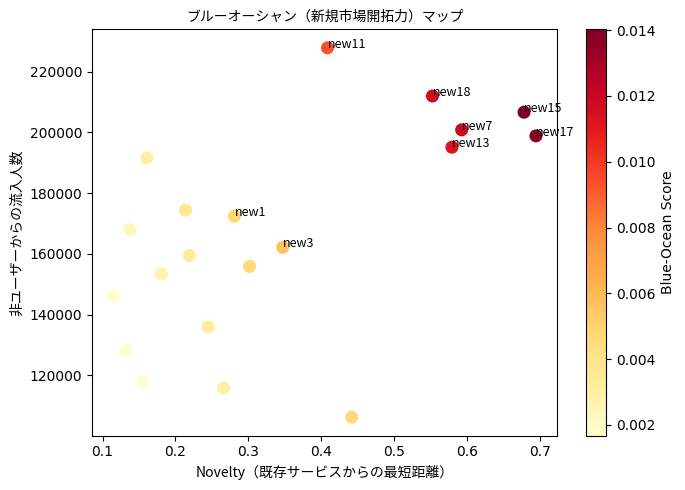

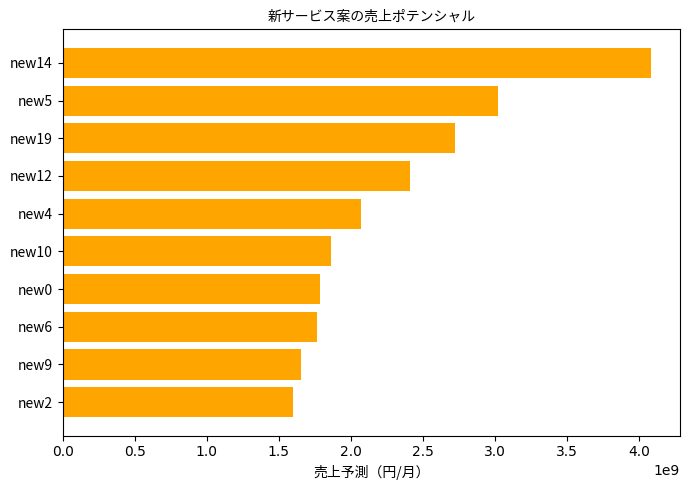

In [9]:
# ----------------------------------------------------------
# 4. 可視化・ランキング出力
# ----------------------------------------------------------
print("=== Blue-Ocean Score TOP10 ===")
display(df_result.head(10))

plt.figure(figsize=(7,5))
plt.scatter(df_result["novelty"], df_result["from_nonuser"], 
            c=df_result["BlueOceanScore"], cmap="YlOrRd", s=70)
plt.colorbar(label="Blue-Ocean Score")
for _, row in df_result.head(8).iterrows():
    plt.text(row.novelty, row.from_nonuser, row.service, fontsize=9,
             fontproperties=font_prop)
plt.xlabel("Novelty（既存サービスからの最短距離）", fontproperties=font_prop)
plt.ylabel("非ユーザーからの流入人数", fontproperties=font_prop)
plt.title("ブルーオーシャン（新規市場開拓力）マップ", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 売上予測上位
plt.figure(figsize=(7,5))
order = np.argsort(df_result["estimated_sales"])[::-1][:10]
plt.barh(range(10), df_result.iloc[order]["estimated_sales"], color="orange")
plt.yticks(range(10), df_result.iloc[order]["service"], fontproperties=font_prop)
plt.xlabel("売上予測（円/月）", fontproperties=font_prop)
plt.title("新サービス案の売上ポテンシャル", fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
